In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 4
k = np.log2(M)
n_channel = 1
R = k/n_channel
power = 2
print('M:',M,'\t','n:',n_channel)

# Channel Parameters
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
num_taps = 1
reyleigh_std = num_taps/np.sqrt(2)

M: 4 	 n: 1


In [4]:
#generating data of size N
N = 16000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [6]:
# checking data shape
data = np.array(data)
print (data.shape)

(16000, 4)


In [7]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

1 [0. 1. 0. 0.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]


In [8]:
# Functions that define the Channel. 

# First the encoder output must be converted to complex samples 
# Right now I am assuming n = 1 for simplicity

def real_to_complex(x):
    real = x[:,0]
    imag = x[:,1]
    return tf.reshape(tf.dtypes.complex(real,imag),shape=[-1,1])

def complex_to_real(x):
    real = tf.math.real(x)
    imag = tf.math.imag(tf.dtypes.cast(x,tf.complex64))
    real_expand = tf.expand_dims(real,-1)
    imag_expand = tf.expand_dims(imag,-1)
    concated = tf.concat([real_expand, imag_expand],-1)
    return tf.reshape(concated,shape=[-1,2])

# Define the Channel Layer for training, as well as the channel function for testing.
# A single tap channel will be implemented initially, and then a multi tap channel will be used.

def reyleigh_single_tap_train (x):
    EbNo_train = K.variable(5.01187, dtype='float32')  #  coverted 7 db of EbNo
    noise_std = K.sqrt(1/(2*R*EbNo_train))
    
    # Create random Complex Channel with single tap
    h_real = 1/np.sqrt(2)*K.random_normal((n_channel,),mean=0,stddev=1)
    h_imag = 1/np.sqrt(2)*K.random_normal((n_channel,),mean=0,stddev=1)
    h = tf.dtypes.complex(h_real,h_imag)
    
    # Create random Complex Gaussian Noise
    noise_real = 1/np.sqrt(2)*K.random_normal((n_channel,),mean=0,stddev=noise_std)
    noise_imag = 1/np.sqrt(2)*K.random_normal((n_channel,),mean=0,stddev=noise_std)
    noise = tf.dtypes.complex(noise_real,noise_imag)
    
    return h*tf.dtypes.cast(x,tf.complex64)+noise

def reyleigh_single_tap (signal,noise_std,nrow,ncol):
    # Create random Complex Channel with single tap
    channel_real = 1/np.sqrt(2)*np.random.randn(nrow,ncol)
    channel_imag = 1/np.sqrt(2)*np.random.randn(nrow,ncol)
    channel = channel_real + 1j*channel_imag
    
    # Create random Complex Gaussian Noise
    noise_real = noise_std/np.sqrt(2)*np.random.randn(nrow,ncol)
    noise_imag = noise_std/np.sqrt(2)*np.random.randn(nrow,ncol)
    noise = noise_real + 1j*noise_imag
    return np.multiply(channel,signal)+noise

def reyleigh_channel(signal,noise_std,nrow,ncol,ntaps):
    output = np.zeros([nrow,ncol])
    
    for L in range(1,ntaps+1):
        channel_std = 1/(L*np.sqrt(2))
        channel = np.multiply(channel_std,np.random.randn(nrow,ncol))
        output = output + np.multiply(signal,channel)

    return output + noise_std*np.random.randn(nrow,ncol)

def reyleigh_train_2(x):
    ntaps = 3
    noise_std = 5.01187 #  coverted 7 db of EbNo
    nrow = 1
    ncol = 2*n_channel
    channel_std = 1/(ntaps)
    output = x*K.random_normal((2*n_channel,),mean=0,stddev=channel_std)
    
    for L in range(2,ntaps+1):
        channel = K.random_normal((2*n_channel,),mean=0,stddev=channel_std)
        output = output + x*channel

    return output + K.random_normal((2*n_channel,),mean=0,stddev=noise_std)

In [9]:
input_signal = Input(shape=(2,))
test1 = Lambda(real_to_complex)(input_signal)
test2 = Lambda(reyleigh_single_tap_train)(test1)
test3 = Lambda(complex_to_real)(test2)
test = Model(input_signal,test1)

input_signal2 = Input(shape=(1,),dtype='complex64')
test4 = Lambda(complex_to_real)(input_signal2)
test5 = Model(input_signal2,test4)

length = 10
test_in = np.reshape(np.arange(0,length*2),(length,2))
test.predict(test_in)

test5.predict(reyleigh_single_tap(test.predict(test_in),1,10,1))

W0719 09:39:00.470963 140086448047936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 09:39:00.471649 140086448047936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 09:39:00.492176 140086448047936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0719 09:39:00.553892 140086448047936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0719 09:39:00.554906 140086448047936 deprecation_wrapper

array([[ -0.9464419 ,   0.68913674],
       [ -1.5816816 ,  -4.448108  ],
       [ -0.60854155,  -2.3497143 ],
       [ -3.5351918 ,  -2.1065853 ],
       [ -5.954816  ,  -6.065078  ],
       [-14.254947  , -21.961578  ],
       [ -9.687916  ,  -7.810955  ],
       [-28.245138  ,   5.808028  ],
       [ 13.604551  ,  -7.4816847 ],
       [ 35.678596  ,  22.645836  ]], dtype=float32)

In [10]:
# Defined Autoencoder

# Transmitter Layers
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(2*n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization()(encoded1)
encoded3 = Lambda(lambda x:2*K.l2_normalize(x,axis=-1))(encoded2)

# Reyleigh Channel Layer
EbNo_train = 5.01187 #  coverted 7 db of EbNo
channel_in = Lambda(real_to_complex)(encoded2)
channel = Lambda(reyleigh_single_tap_train)(channel_in)
channel_out = Lambda(complex_to_real)(channel)

# Reciever Layer
decoded = Dense(256, activation='relu')(channel_out)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
sgd = SGD(lr=0.03)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

W0719 09:39:01.420792 140086448047936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [11]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 8         
_________________________________________________________________
lambda_6 (Lambda)            (None, 1)                 0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 1)                 0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 2)                 0         
__________

In [12]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=50,
                batch_size=2048)

W0719 09:39:01.514925 140086448047936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
16000/16000 [==============================] - 1s 37us/step - loss: 1.3598
Epoch 2/50
16000/16000 [==============================] - 0s 2us/step - loss: 1.5998
Epoch 3/50
16000/16000 [==============================] - 0s 2us/step - loss: 1.3338
Epoch 4/50
16000/16000 [==============================] - 0s 2us/step - loss: 1.2236
Epoch 5/50
16000/16000 [==============================] - 0s 2us/step - loss: 1.0742
Epoch 6/50
16000/16000 [==============================] - 0s 2us/step - loss: 1.0485
Epoch 7/50
16000/16000 [==============================] - 0s 2us/step - loss: 1.1826
Epoch 8/50
16000/16000 [==============================] - 0s 2us/step - loss: 0.9103
Epoch 9/50
16000/16000 [==============================] - 0s 2us/step - loss: 1.1705
Epoch 10/50
16000/16000 [==============================] - 0s 2us/step - loss: 0.9636
Epoch 11/50
16000/16000 [==============================] - 0s 2us/step - loss: 0.8501
Epoch 12/50
16000/16000 [==============================] - 0s 

In [13]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)

In [14]:
# making channel from full autoencoder
channel_input = Input(shape=(2*n_channel,))

chan = autoencoder.layers[-5](channel_input)
chan = autoencoder.layers[-4](chan)
chan = autoencoder.layers[-3](chan)
channel_layer = Model(channel_input,chan)

In [15]:
# making decoder from full autoencoder
encoded_input = Input(shape=(2*n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [16]:
# generating data for checking BER
N = 70000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [17]:
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

(4, 1, 2)


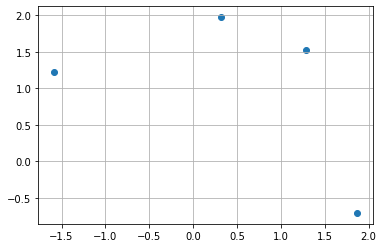

In [18]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

(4, 1, 2)


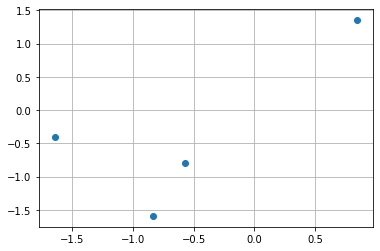

In [19]:
# for plotting learned consteallation diagram after reyliegh channel

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(channel_layer.predict(encoder.predict(np.expand_dims(temp,axis=0))))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

In [20]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(np.arange(0,20+1,2))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    encoded_signal = encoder.predict(test_data) 
    final_signal = reyleigh_single_tap(encoded_signal,noise_std,nn,1)
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


SNR: 0 BER: 0.7480714285714286
SNR: 2 BER: 0.7503142857142857
SNR: 4 BER: 0.7498
SNR: 6 BER: 0.7530714285714286
SNR: 8 BER: 0.7554857142857143
SNR: 10 BER: 0.7592571428571429
SNR: 12 BER: 0.7605142857142857
SNR: 14 BER: 0.7583285714285715
SNR: 16 BER: 0.7580714285714286
SNR: 18 BER: 0.7622857142857142
SNR: 20 BER: 0.7586428571428572


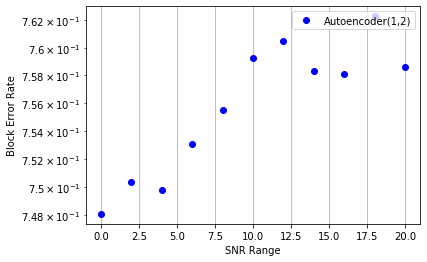

In [21]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(1,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.show()